In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3804655/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
MAX_BATCH_SIZE = 9
ORG_NAME = "PancakeSwap"
SPLITS_FREQ = "3d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2023-06-27"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3119 entries, 0 to 3118
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3119 non-null   object        
 1   author             3119 non-null   object        
 2   date               3119 non-null   datetime64[us]
 3   start              3119 non-null   datetime64[us]
 4   end                3119 non-null   datetime64[us]
 5   platform_proposal  3119 non-null   object        
dtypes: datetime64[us](3), object(3)
memory usage: 146.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532830 entries, 0 to 532829
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        532830 non-null  object        
 1   proposal  532830 non-null  object        
 2   voter     532830 non-null  object        
 3   date      532830 non-null  datetime64[

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/PancakeSwap/baseline/folds-info_3d_normalize.parquet
fold
2023-06-21    525836
2023-06-24    527714
2023-06-27    528366
2023-06-30    529073
2023-07-03    529754
2023-07-06    531109
2023-07-09    532202
2023-07-12    532230
2023-07-15    532325
2023-07-18    532364
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W25,126,3205,1309,25.44,2.45,681,234,5.40,2.91
2023-W25,75,3501,1564,46.68,2.24,833,376,11.11,2.22
2023-W26,57,2314,1075,40.60,2.15,358,152,6.28,2.36
2023-W26,49,2036,946,41.55,2.15,245,127,5.00,1.93
2023-W27,7,334,278,47.71,1.20,208,96,29.71,2.17
2023-W27,9,1010,684,112.22,1.48,501,290,55.67,1.73
2023-W27,6,395,297,65.83,1.33,134,61,22.33,2.20
2023-W28,6,423,307,70.50,1.38,114,52,19.00,2.19
2023-W28,2,201,143,100.50,1.41,26,19,13.00,1.37


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W25 & 126 & 3205 & 1309 & 25.44 & 2.45 & 681 & 234 & 5.40 & 2.91 \\
2023-W25 & 75 & 3501 & 1564 & 46.68 & 2.24 & 833 & 376 & 11.11 & 2.22 \\
2023-W26 & 57 & 2314 & 1075 & 40.60 & 2.15 & 358 & 152 & 6.28 & 2.36 \\
2023-W26 & 49 & 2036 & 946 & 41.55 & 2.15 & 245 & 127 & 5.00 & 1.93 \\
2023-W27 & 7 & 334 & 278 & 47.71 & 1.20 & 208 & 96 & 29.71 & 2.17 \\
2023-W27 & 9 & 1010 & 684 & 112.22 & 1.48 & 501 & 290 & 55.67 & 1.73 \\
2023-W27 & 6 & 395 & 297 & 65.83 & 1.33 & 134 & 61 & 22.33 & 2.20 \\
2023-W28 & 6 & 423 & 307 & 70.50 & 1.38 & 114 & 52 & 19.00 & 2.19 \\
2023-W28 & 2 & 201 & 143 & 100.50 & 1.41 & 26 & 19 & 13.00 & 1.37 \\
2023-W29 & 0

## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/251 [00:00<?, ?it/s]

Warning, empty test fold 0 (2021-06-28 00:00:00), all ok since 0 folds ago


Warning, test fold 249 (2023-07-15 00:00:00) with less than 5 open proposals (2). all ok since 249 folds ago


Warning, empty test fold 250 (2023-07-18 00:00:00), all ok since 250 folds ago


Max ok in a row: (250, Timestamp('2023-07-18 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/PancakeSwap/baseline/openpop_3d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,...,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.071085,0.062663,0.057714,0.048284,0.044987,0.025942,0.071067,0.104020,0.122225,0.143695,...,0.212681,0.271665,0.858960,0.395410,0.341153,0.331547,0.347997,0.365766,0.415242,0.558458
std,0.132326,0.078653,0.063825,0.042768,0.034757,0.012208,0.132308,0.155797,0.164955,0.171036,...,0.238088,0.250257,0.163466,0.260108,0.224133,0.222519,0.216005,0.209518,0.194072,0.308345
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070868
25%,0.010715,0.012793,0.014326,0.017754,0.024100,0.018948,0.010715,0.016680,0.021877,0.033671,...,0.052476,0.085207,0.811857,0.180256,0.190831,0.192656,0.213308,0.232633,0.268317,0.390084
50%,0.019231,0.027923,0.028916,0.031672,0.033990,0.024000,0.019231,0.029977,0.037460,0.054188,...,0.082743,0.163514,0.913732,0.333333,0.265107,0.241746,0.253576,0.273699,0.376279,0.501094
75%,0.046735,0.094423,0.081837,0.065014,0.057715,0.030154,0.046735,0.146596,0.171559,0.191852,...,0.323181,0.405567,0.970421,0.583742,0.379095,0.402730,0.429049,0.440521,0.466416,0.648640
max,0.887033,0.456140,0.369231,0.253479,0.211551,0.109650,0.887033,0.888368,0.890224,0.903499,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.255338


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/PancakeSwap/baseline/perfect_3d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,...,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.992032,0.547292,0.391831,0.235123,0.167962,0.028963,0.992032,0.992032,0.992032,0.992032,...,0.973692,0.981895,0.992027,0.718017,0.894842,0.939606,0.973692,0.981895,0.992027,0.235639
std,0.089086,0.094043,0.095352,0.082033,0.063642,0.013420,0.089086,0.089086,0.089086,0.089086,...,0.091018,0.089795,0.089085,0.120039,0.107345,0.098145,0.091018,0.089795,0.089085,0.121287
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072867
25%,1.000000,0.503415,0.344966,0.193248,0.134297,0.021484,1.000000,1.000000,1.000000,1.000000,...,0.979998,0.987528,1.000000,0.688486,0.891421,0.941490,0.979998,0.987528,1.000000,0.185151
50%,1.000000,0.543094,0.382051,0.219780,0.156863,0.026777,1.000000,1.000000,1.000000,1.000000,...,0.985819,0.993292,1.000000,0.732824,0.916379,0.958369,0.985819,0.993292,1.000000,0.208461
75%,1.000000,0.579806,0.415789,0.247464,0.180433,0.032639,1.000000,1.000000,1.000000,1.000000,...,0.992174,0.997003,1.000000,0.783584,0.940177,0.972648,0.992174,0.997003,1.000000,0.230284
max,1.000000,0.888282,0.746521,0.581446,0.520629,0.120332,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.955947,1.000000,1.000000,1.000000,1.000000,1.000000,1.238984


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,251,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,...,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,0.0,0.0
mean,2022-07-08 00:00:00,0.071085,0.062663,0.057714,0.048284,0.044987,0.025942,0.071067,0.104020,0.122225,...,0.858960,0.395410,0.341153,0.331547,0.347997,0.365766,0.415242,0.558458,NaN,NaN
min,2021-06-28 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070868,NaN,NaN
25%,2022-01-01 12:00:00,0.010715,0.012793,0.014326,0.017754,0.024100,0.018948,0.010715,0.016680,0.021877,...,0.811857,0.180256,0.190831,0.192656,0.213308,0.232633,0.268317,0.390084,NaN,NaN
50%,2022-07-08 00:00:00,0.019231,0.027923,0.028916,0.031672,0.033990,0.024000,0.019231,0.029977,0.037460,...,0.913732,0.333333,0.265107,0.241746,0.253576,0.273699,0.376279,0.501094,NaN,NaN
75%,2023-01-11 12:00:00,0.046735,0.094423,0.081837,0.065014,0.057715,0.030154,0.046735,0.146596,0.171559,...,0.970421,0.583742,0.379095,0.402730,0.429049,0.440521,0.466416,0.648640,NaN,NaN
max,2023-07-18 00:00:00,0.887033,0.456140,0.369231,0.253479,0.211551,0.109650,0.887033,0.888368,0.890224,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.255338,NaN,NaN
std,NaN,0.132326,0.078653,0.063825,0.042768,0.034757,0.012208,0.132308,0.155797,0.164955,...,0.163466,0.260108,0.224133,0.222519,0.216005,0.209518,0.194072,0.308345,NaN,NaN


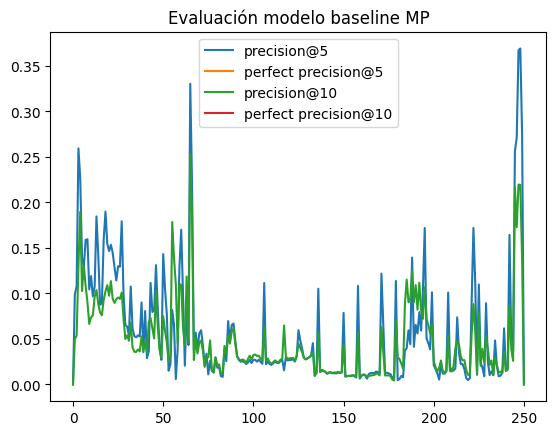

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,2023-07-04 12:00:00,0.179785,0.201951,0.180403,0.113265,0.079463,0.018404,0.179785,0.311642,0.371895,...,0.877773,0.521042,0.505945,0.525960,0.523234,0.521847,0.524394,0.211864,NaN,NaN
min,2023-06-21 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070868,NaN,NaN
25%,2023-06-27 18:00:00,0.019765,0.058882,0.040189,0.029192,0.035240,0.017780,0.019765,0.083481,0.086979,...,1.000000,0.333185,0.341282,0.343348,0.348180,0.352466,0.359383,0.135428,NaN,NaN
50%,2023-07-04 12:00:00,0.049234,0.241319,0.210306,0.111639,0.075845,0.021795,0.049234,0.308604,0.404475,...,1.000000,0.576216,0.379095,0.464974,0.470000,0.470000,0.470000,0.166965,NaN,NaN
75%,2023-07-11 06:00:00,0.292110,0.270623,0.273022,0.205690,0.137126,0.022107,0.292110,0.385813,0.557876,...,1.000000,0.665713,0.784492,0.784027,0.774461,0.775375,0.776682,0.226773,NaN,NaN
max,2023-07-18 00:00:00,0.684211,0.456140,0.369231,0.219672,0.146448,0.023553,0.684211,0.883452,0.883452,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.473896,NaN,NaN
std,NaN,0.247909,0.160093,0.145575,0.090346,0.056444,0.007120,0.247909,0.289310,0.310425,...,0.316229,0.278996,0.334187,0.311347,0.310973,0.312426,0.310919,0.128736,NaN,NaN
